In [67]:
import numpy as np
import splitfolders
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
import os
import cv2
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

In [68]:
splitfolders.ratio('data', output="data_split", seed=42, ratio=(0.8, 0.1, 0.1)) # default values

In [69]:
def load_images(folder, size=(128, 128)):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if not os.path.isdir(label_folder):
            continue
        for filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, size)
                images.append(img.flatten())
                labels.append(label)
    return np.array(images), np.array(labels)

X_train, y_train = load_images("data_split/train")
X_test, y_test = load_images("data_split/test")

# Min-Max Scaling
X_train = X_train / 255.0
X_test = X_test / 255.0

In [70]:
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [71]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)


In [72]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_pca, y_train_enc)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [73]:
y_pred = knn.predict(X_test_pca)

In [85]:
probs = knn.predict_proba(X_test_pca)  # shape: (num_samples, num_classes)
preds = knn.predict(X_test_pca)

entropy_uncertainty = -np.sum(probs * np.log(probs + 1e-12), axis=1)
entropy_mean = np.mean(entropy_uncertainty)
entropy_median = np.median(entropy_uncertainty)
entropy_max = np.max(entropy_uncertainty)
entropy_min = np.min(entropy_uncertainty)
entropy_std = np.std(entropy_uncertainty)

print(entropy_uncertainty)

print("Entropy-based uncertainty metrics:")
print(f"Mean: {entropy_mean:.4f}, Median: {entropy_median:.4f}, Max: {entropy_max:.4f}, Min: {entropy_min:.4f}, Std: {entropy_std:.4f}")

sample_idx = np.arange(len(entropy_uncertainty))

sns.set(style="whitegrid")

[-1.00008890e-12  6.73011667e-01 -1.00008890e-12  6.73011667e-01
 -1.00008890e-12 -1.00008890e-12 -1.00008890e-12 -1.00008890e-12
  5.00402424e-01 -1.00008890e-12  5.00402424e-01  5.00402424e-01
 -1.00008890e-12  5.00402424e-01  5.00402424e-01  5.00402424e-01
  5.00402424e-01 -1.00008890e-12 -1.00008890e-12  6.73011667e-01
  5.00402424e-01  5.00402424e-01 -1.00008890e-12  5.00402424e-01
  6.73011667e-01  5.00402424e-01  5.00402424e-01]
Entropy-based uncertainty metrics:
Mean: 0.3221, Median: 0.5004, Max: 0.6730, Min: -0.0000, Std: 0.2732


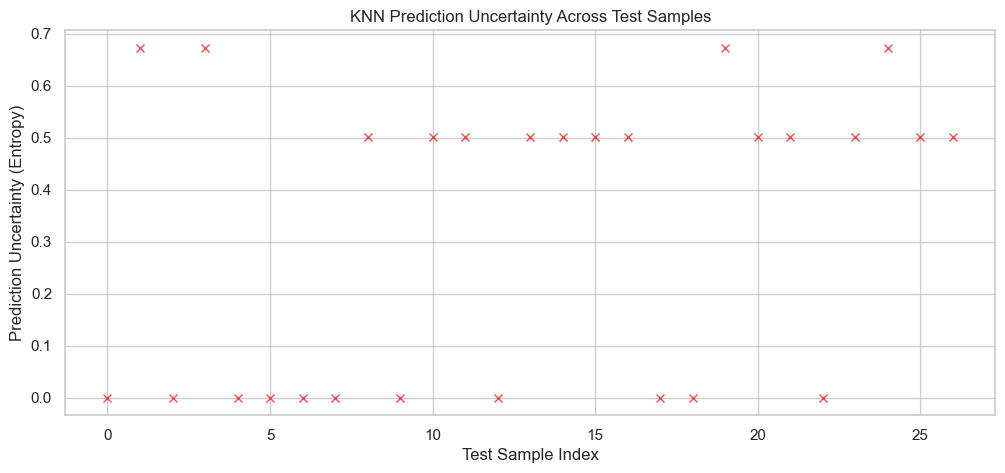

In [84]:
plt.figure(figsize=(12, 5))
plt.plot(sample_idx, entropy_uncertainty, marker='x', linestyle='', color='red', alpha=0.7, label='Entropy')
plt.xlabel("Test Sample Index")
plt.ylabel("Prediction Uncertainty (Entropy)")
plt.title("KNN Prediction Uncertainty Across Test Samples")
plt.grid(True)
plt.show()

In [50]:
print("Accuracy:", accuracy_score(y_test_enc, y_pred))
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

Accuracy: 0.8148148148148148
              precision    recall  f1-score   support

          no       0.71      0.91      0.80        11
         yes       0.92      0.75      0.83        16

    accuracy                           0.81        27
   macro avg       0.82      0.83      0.81        27
weighted avg       0.84      0.81      0.82        27



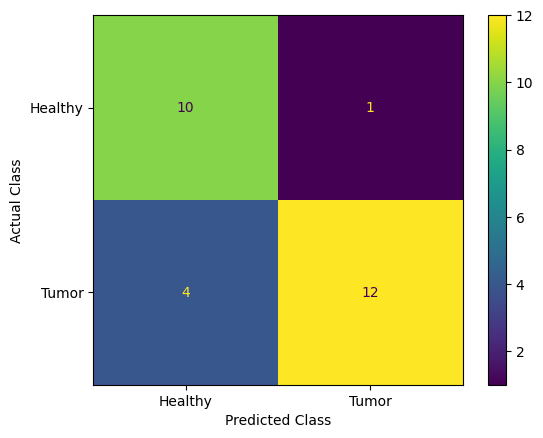

In [51]:
confusion_matrix = metrics.confusion_matrix(y_test_enc, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Healthy", "Tumor"])

cm_display.plot()
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

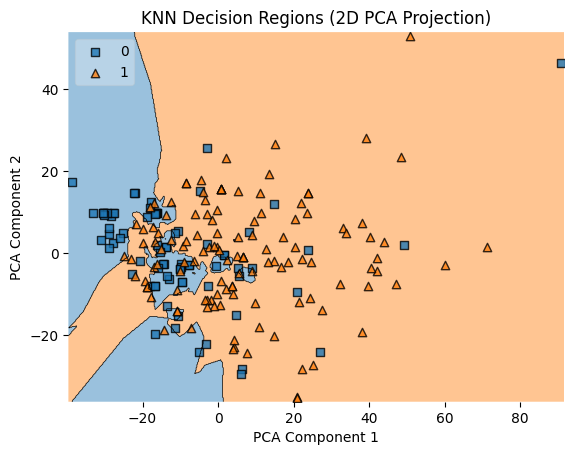

In [52]:
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(X_train)

knn_vis = KNeighborsClassifier(n_neighbors=5)
knn_vis.fit(X_vis, y_train_enc)

plot_decision_regions(X_vis, y_train_enc, clf=knn_vis, legend=2)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("KNN Decision Regions (2D PCA Projection)")
plt.show()